### the randomized experiment (RCT/ AB test)

reminder:

correlation (more generally, *association*) is not causation

...unless...maybe.. it is.

we have a treatment/intervention $ X \in \{0,1\}$

and we have an outcome variable $ Y $

`avg(Y | X = 1) - avg(Y | X = 0) = avg treatment effect (on the treated) + bias`

for now, let's give hand-wavy definitions:

treatment effect = "avg difference in $Y$ when the treatment is given vs when it is not given"

bias = "avg difference in $Y$ if noone got the treatment"

the nice thing about AB tests, is that they are designed to eliminate bias

how?

bias can be eliminated through random assignment of $X$.


**data source**:

[cookie cats](https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#cats = pd.read_csv('../cookie_cats.csv')
cats = pd.read_csv('/Users/alenadocherty/Downloads/Projects/Cookie_cats/cookie_cats.csv')

# mobile gaming dataset
# quite large: tens of thousands of observations

# we have to make up a story about the experimental set up:

# we have a mobile game (a game you play on your cell phone)
# intervention/experimental condition/X - "the thing that's different between the two groups"
# group A sees the gate at level 30
# group B sees the gate at level 40
# we measure 3 outcomes as a function of the intervention:
# total number of games played from the moment the experiment was launched to 14 days after.
# and retention .. after 1 day and after 7 days.

# let's assume prior to the experiment ALL players saw the gate at level 30
# that would mean the experimental condition is "player sees the gate at level 40"

cats.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


<Axes: title={'center': 'percentage of players who return after 7 days'}, xlabel='version', ylabel='%'>

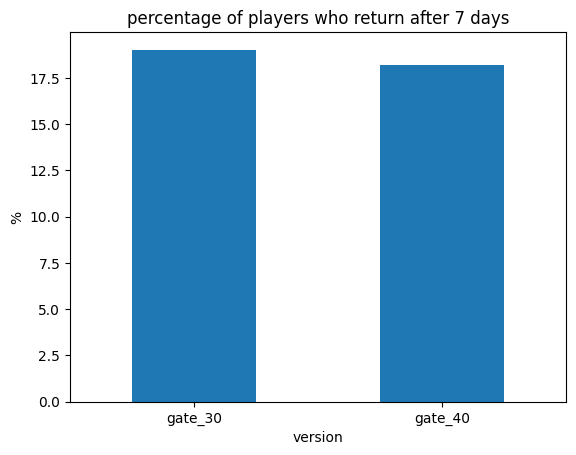

In [2]:
import matplotlib.pyplot as plt

retention_7_barplot_data = cats.groupby('version')['retention_7'].mean()*100

retention_7_barplot_data.plot.bar(title = "percentage of players who return after 7 days",rot = 0,ylabel = "%")

quick review

pvalue what does it mean?

probability of type 1 error, i.e. false positive rate, i.e. probability of rejecting the null hypothesis when you should NOT have

pvalue = "in a world where there's no difference between group A and B, we should expect to see data that looks like this pvalue percentage of the time"

if you do 1,000,000 hypothesis tests and get 1,000,000 pvalues of .0499999 (which leads you to reject the null every time) you will have 50,000 false positives. 

In [3]:
# randomization - we have to take it for granted here.
# what data would we need to do the random assignment ourselves
# we want to make sure that "on average" the players in group A and B 
# had the same level of engagement before the experiment

# what hypothesis test should we use
# t-test, specifically two-sample unpaired independent t-test

# null hypothesis: mean(sum of game rounds for group A) - mean(sum of game rounds for group B) = 0
# alternative hypothesis: ~null hypothesis 
# mean(sum of game rounds for group A) - mean(sum of game rounds for group B) != 0

# significance threshold
# most people arbitrarily use .05
# if p(false positive) < .05 we will decide to kind of believe the result

gate_30 = cats.loc[cats['version'] == "gate_30","sum_gamerounds"] # group A
gate_40 = cats.loc[cats['version'] == "gate_40","sum_gamerounds"] # group B

from scipy.stats import ttest_ind
ttest_ind(gate_30,gate_40)

Ttest_indResult(statistic=0.8910426211362967, pvalue=0.37290868247405207)

interpretation:

we fail to reject the null hypothesis

let's check our intuition about hypothesis testing

we've done this experiment...and now we want to explain where the variability in the data comes from, and there's really only three options:

**option 1**: all the variability is due to the systematic effect of the treatment

`gate_30_gr = (120, 120, 120, 120, ....)`

`gate_40_gr = (119, 119, 119, 119, ....)`

as you can see, this is highly unlikely to be the case.

**option 2**: all the variability is due to randomness (noise) 

**^^^ when we do a hypothesis test, we're testing this ^^^**

**option 3:** the variability is some combination of systematic effect and noise

**^^^ when we reject the null, we are choosing to believe this ^^^**


In [4]:
# next
# 7 day retention (rate, category) ~ version (categorical (gate_30,40))
# proportions z test
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
# prep the data
retention_gate_30 = cats.loc[cats['version'] == "gate_30","retention_7"] # group A
retention_gate_40 = cats.loc[cats['version'] == "gate_40","retention_7"] # group B
count = np.array([retention_gate_30.sum(),retention_gate_40.sum()])
nobs = np.array([retention_gate_30.shape[0],retention_gate_40.shape[0]])
# run the test
# wait a sec
# what are the null/alt hypotheses
# null: retention rate gate_30 = retention_rate gate_40
# alt:  retention rate gate_30 != retention_rate gate_40 (or just: ~null)

_, pval = proportions_ztest(count, nobs)
# print the result
print(f'{round(pval,3)}')


0.002


In [5]:
# the test only hints at the strength and direction of the effect
# we need to take a closer look
cats.groupby('version')['retention_7'].agg(['sum','mean'])

,sum,mean
version,,
gate_30,8502,0.190201
gate_40,8279,0.182000


there's usually more than one way to answer the same question

statistical methods are like little robots - some are designed for a single purpose and others have more flexible capabilities

for example, we used a t-test to evaluate sum_gamerounds (numeric) ~ version (categorical)

are there other tools that we could apply. what about a regression?

`avg(sum_gamerounds | version) = beta0 + beta_version*version{1,0}`

In [6]:
cats.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


## #7 issue EDA - explore the relationship between the different outcome variables

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math
import scipy.stats
from scipy.stats import probplot, chi2_contingency, chi2, kstest
from scipy.stats import spearmanr, kendalltau
import statsmodels.api as sm
from statsmodels.formula.api import logit

In [8]:
cats = pd.read_csv('../cookie_cats.csv') # you might adjust for your own path
#cats = pd.read_csv('/Users/alenadocherty/Downloads/Projects/Cookie_cats/cookie_cats.csv')

# mobile gaming dataset

In [9]:
# Initial statistics for sum_gamerounds
print("Initial descriptive Statistics for sum_gamerounds:")
print(cats['sum_gamerounds'].describe())

Initial descriptive Statistics for sum_gamerounds:
count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64


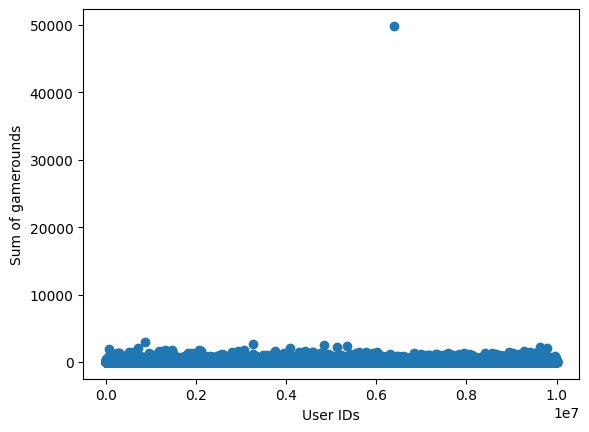

In [10]:
# checking for outliers

cats_plot_data = cats.groupby('userid')['sum_gamerounds'].sum().sort_values(ascending=False).reset_index()
plt.figure()
plt.scatter(x= cats_plot_data['userid'], y = cats_plot_data['sum_gamerounds'] )
plt.xlabel('User IDs')
plt.ylabel('Sum of gamerounds')
#plt.gca().set_xscale('log')
plt.show()


In [11]:
# removing outlier from dataset, creating a copy

def remove_outlier(df, column):

    df_cleaned = df.copy(deep=True)
    max_value = df[column].max()

    print(f"Max gamerounds in {column} is {max_value}")

    df_cleaned = df_cleaned.loc[df_cleaned[column] != max_value]

    return df_cleaned

cats_cleaned = remove_outlier(cats, 'sum_gamerounds')

cats_cleaned.head(3) #  cats_cleaned.shape (90188, 5)


Max gamerounds in sum_gamerounds is 49854


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


In [12]:
# Descriptive statistics after removing outlier
print("Descriptive statistics for sum_gamerounds:")
print(cats_cleaned['sum_gamerounds'].describe())

Descriptive statistics for sum_gamerounds:
count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64


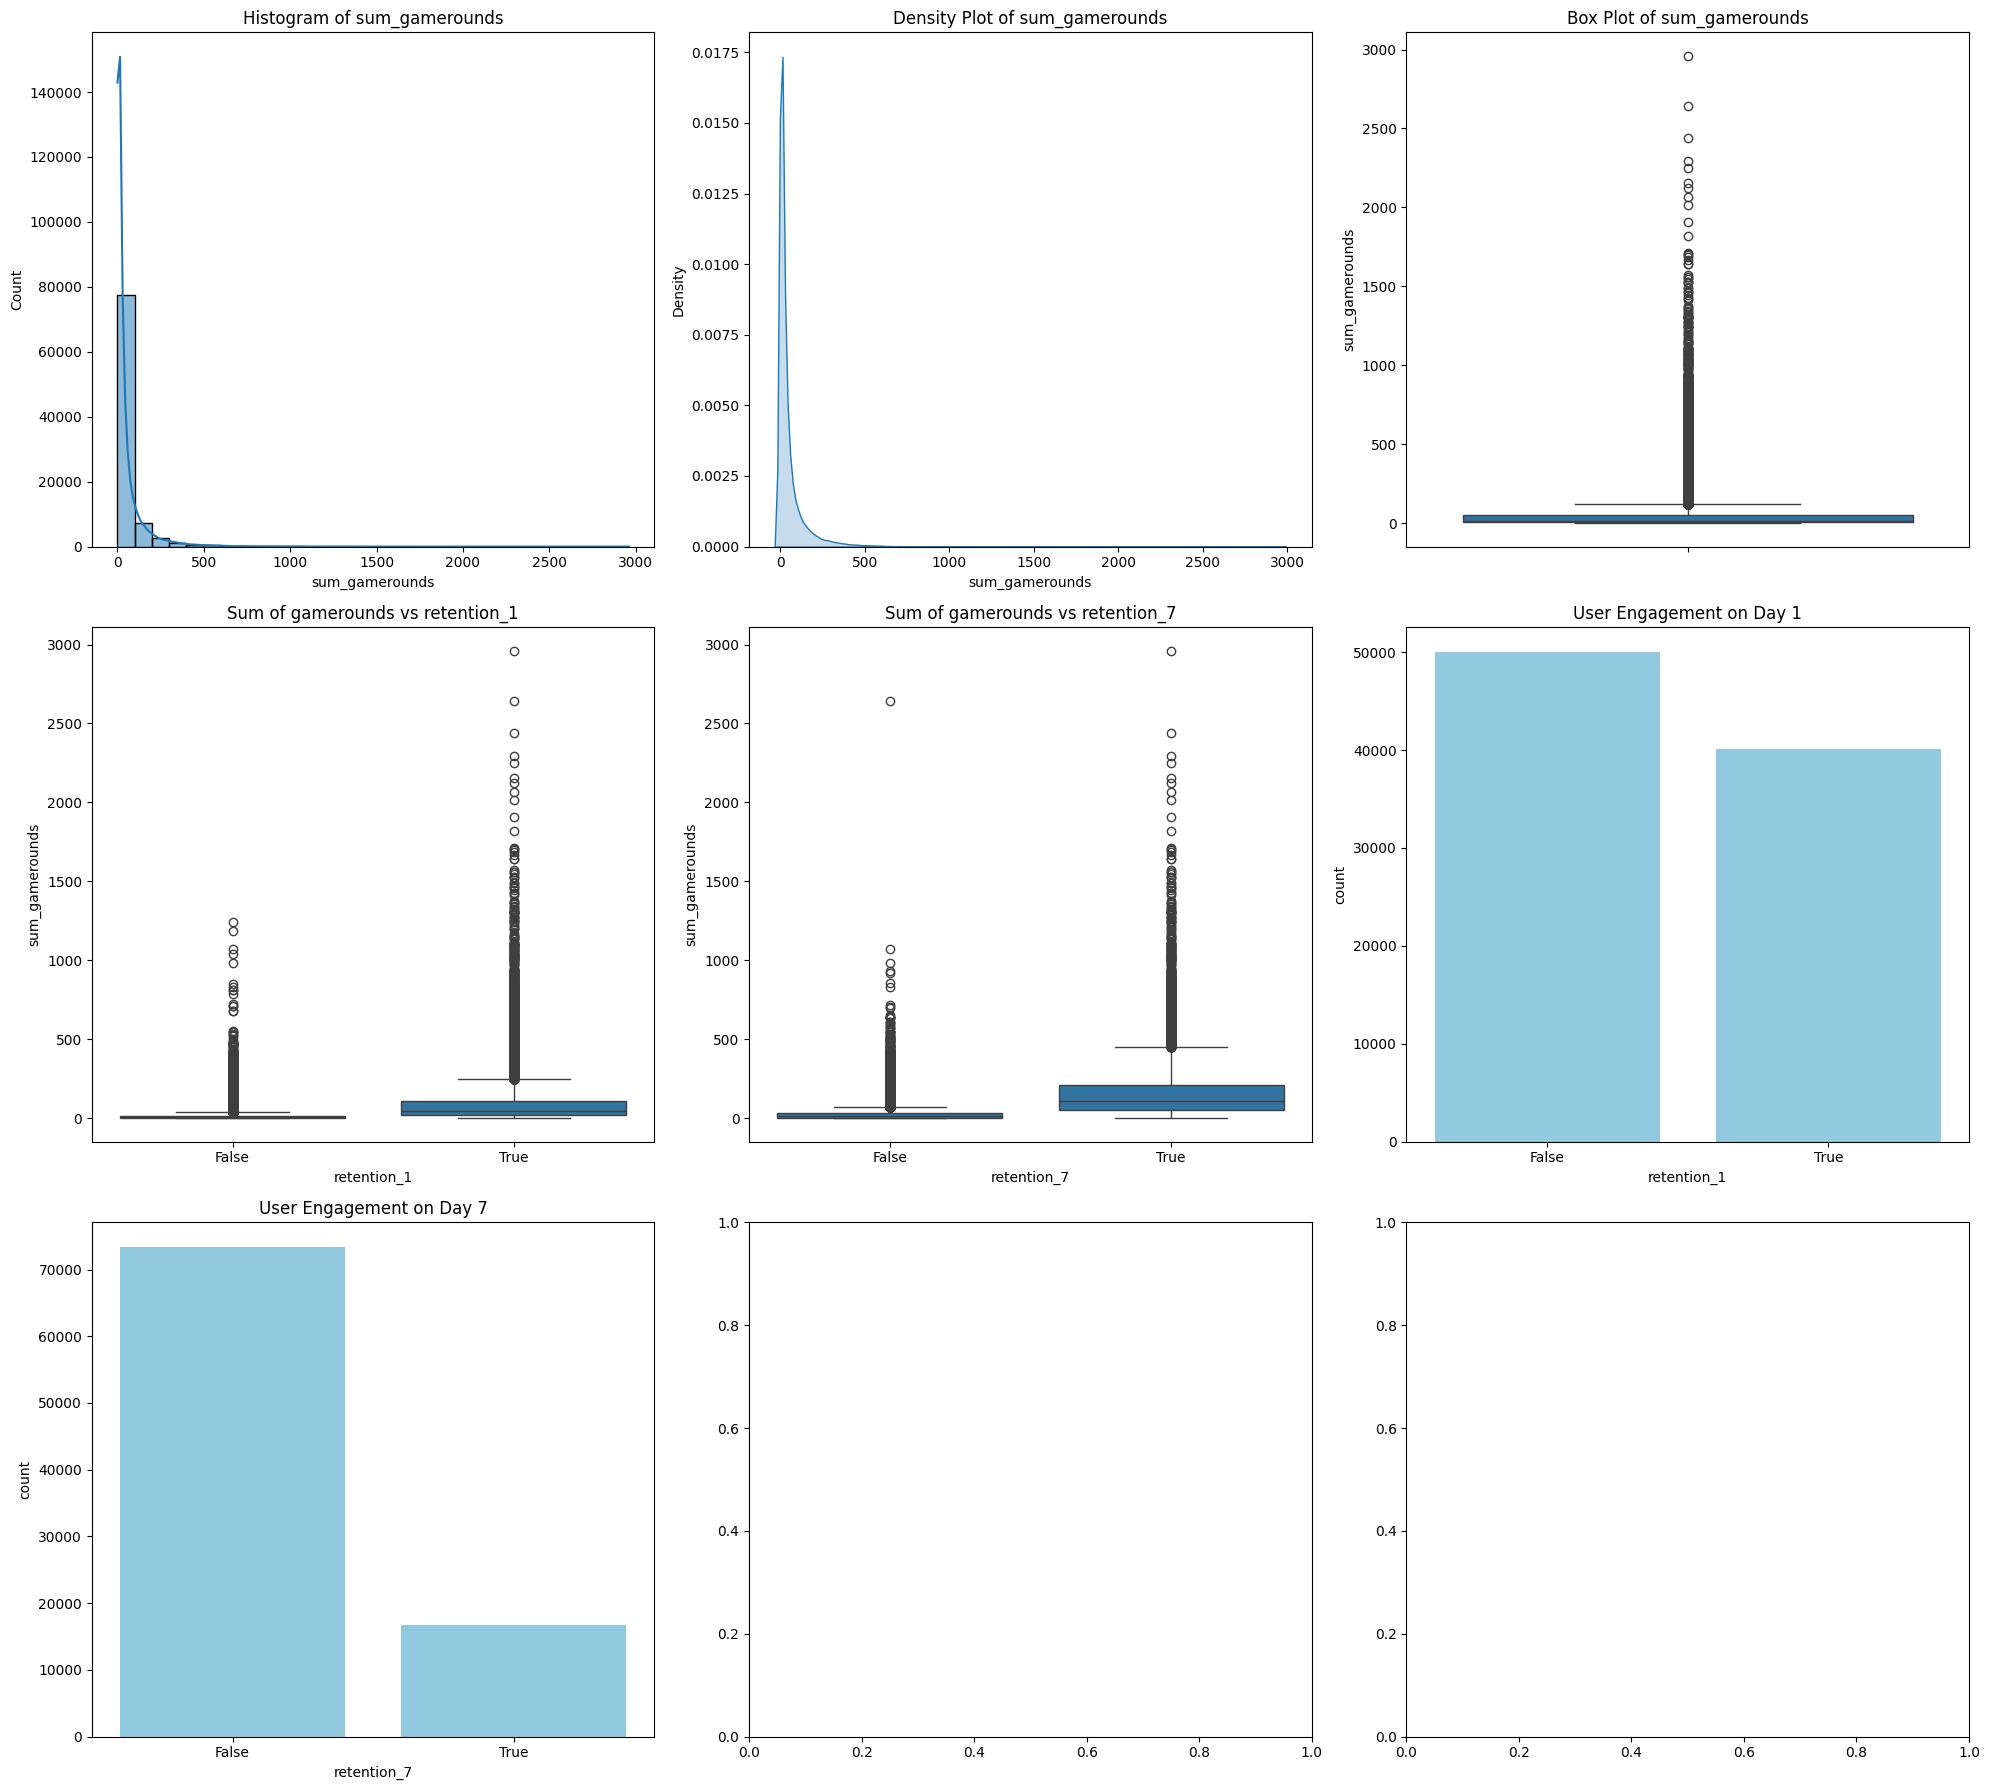

In [13]:
# visual inspection for normality

def plot_histogram_with_kde(data, column, ax, title ):
    sns.histplot(data[column], bins =30, kde=True, ax=ax)
    ax.set_title(title)

def plot_density(data, column, ax, title):   
    sns.kdeplot(data[column], fill=True, ax=ax)
    ax.set_title(title)

def plot_box(data, column, ax, title ):
    sns.boxplot(y=data[column], ax=ax)
    ax.set_title(title)

def plot_box_subgroup(data, subgroup, column, ax, title ):  
    sns.boxplot(x= subgroup, y=data[column], data= data, ax=ax)
    ax.set_title(title)

def plot_count(data, column, ax, title ):
    sns.countplot(x=column, data= data, color='skyblue', ax=ax) 
    ax.set_title(title)

def plot_visual_inspection(data):
    fig, axes = plt.subplots(3,3, figsize = (20, 18))  

    plot_histogram_with_kde(data, 'sum_gamerounds', axes[0, 0], 'Histogram of sum_gamerounds')
    plot_density(data, 'sum_gamerounds', axes[0, 1],'Density Plot of sum_gamerounds') 
    plot_box(data, 'sum_gamerounds', axes[0, 2], 'Box Plot of sum_gamerounds' )
    plot_box_subgroup(data, 'retention_1' ,'sum_gamerounds', axes[1, 0], 'Sum of gamerounds vs retention_1')
    plot_box_subgroup(data, 'retention_7' ,'sum_gamerounds', axes[1, 1], 'Sum of gamerounds vs retention_7' )
    plot_count(data, 'retention_1' , axes[1,2], 'User Engagement on Day 1')
    plot_count(data, 'retention_7' , axes[2,0], 'User Engagement on Day 7')
    
    plt.tight_layout()
    plt.show()
    
plot_visual_inspection(cats_cleaned)    

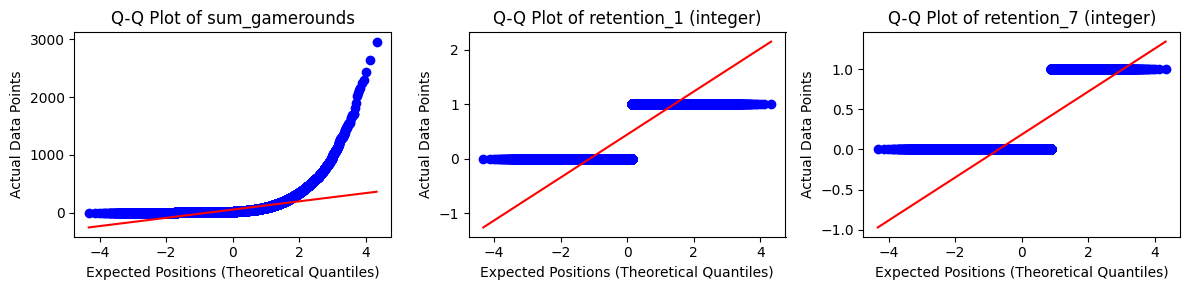

In [14]:
# Q-Q plots for normality check   

# Converting 'retention_1' and 'retention_7' to integer
def colunm_to_integer(data, column):
    return data[column].astype(int) 
          
def plot_probplot(data, column, distribution, axis, title, xlabel, ylabel):
    probplot(data[column], dist=distribution, plot=axis )
    axis.set_title(title)   
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)

def plot_probplot_subgroup(subgroup, distribution, axis, title, xlabel, ylabel):
    probplot(subgroup, dist=distribution, plot=axis)
    axis.set_title(title)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)    

def plot_q_q_plots(data):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

    plot_probplot(data, 'sum_gamerounds',  'norm', ax1,'Q-Q Plot of sum_gamerounds', 'Expected Positions (Theoretical Quantiles)','Actual Data Points') 
    
    plot_probplot_subgroup(cats_cleaned_r1_int, 'norm', ax2, 'Q-Q Plot of retention_1 (integer)', 'Expected Positions (Theoretical Quantiles)','Actual Data Points')  
    plot_probplot_subgroup(cats_cleaned_r7_int, 'norm', ax3, 'Q-Q Plot of retention_7 (integer)', 'Expected Positions (Theoretical Quantiles)','Actual Data Points')     
        
    plt.tight_layout()
    plt.show()

cats_cleaned_r1_int = colunm_to_integer(cats_cleaned, 'retention_1')
cats_cleaned_r7_int = colunm_to_integer(cats_cleaned, 'retention_7')
    
# Plot Q-Q plots using the converted to integer columns
plot_q_q_plots(cats_cleaned)

In [15]:
# checking for ties before deciding on normality test
def check_for_ties(data, column1, column2):
    data_cleaned_grouped_for_duplicates = data.copy(deep = True).groupby(column1)[column2].nunique().reset_index()    
    # total number of duplicated rows
    tndr = data_cleaned_grouped_for_duplicates.duplicated(subset=[column2], keep = False).sum() 

    # number of duplicated rows excluding the first occurence 
    ndrefo = data_cleaned_grouped_for_duplicates.duplicated(subset= [column2]).sum() 

    print(f"Total number of duplicated rows: {tndr}")
    print(f"Number of ties (unique duplicated rows): {tndr-ndrefo}") 
    
check_for_ties(cats_cleaned, 'sum_gamerounds', 'userid')

Total number of duplicated rows: 822
Number of ties (unique duplicated rows): 71


In [16]:
# Normality Tests

# shapiro_test = stats.shapiro(cats_cleaned['sum_gamerounds'])                # cons: large dataset, discrete features
# anderson_test = stats.anderson(cats_cleaned['sum_gamerounds'], dist='norm') # cons: ties, discrete features

# Kolmogrov-Smirnov normality test 
def calculate_ks_test(data, column):
    # Sample size
    n = data.shape[0]
    mean = data[column].mean()
    std = data[column].std()
    alpha = 0.05
    
    ks_test = kstest(data[column], 'norm', args = (mean, std))
    ks_pvalue = ks_test.pvalue 
    ks_test_statistic  = ks_test.statistic 
    ks_critical_value = 1.36/np.sqrt(n) # 1.36 a value from One-Sample Kolmogrov-Smirnov Table for significance level of 0.05 
    
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_test_statistic}, p-value={ks_pvalue}, ks-critical value={ks_critical_value}")

    if  ks_pvalue < alpha:
        print('The data does not follow normal distribution (based on p-value)')
    else:
        print('The data follows normal distribution (based on p-value)')  

    if  ks_test_statistic >  ks_critical_value:
        print('The data does not follow normal distribution (based on critical value and test statistic)')  
    else:
        print('The data does not follow normal distribution (based on p-critical value and test statistic)')      
    
    #return ks_pvalue, ks_test_statistic, ks_critical_value, mean, std
  
calculate_ks_test(cats_cleaned, 'sum_gamerounds')

Kolmogorov-Smirnov Test: Statistic=0.30860990915362607, p-value=0.0, ks-critical value=0.004528605923506019
The data does not follow normal distribution (based on p-value)
The data does not follow normal distribution (based on critical value and test statistic)


In [17]:
# Spearman's Rank and Kendall's Tau correlation coefficients
def calculate_correlation(df, column1, column2, method='both'):
   
    methods = {
        'spearman': df[column1].corr(df[column2], method='spearman'),
        'kendall': df[column1].corr(df[column2], method='kendall')
    }
    if method == 'both':
        return methods
    else:
        return {method: methods[method]}
      
r1_all = calculate_correlation(cats, 'sum_gamerounds', 'retention_1')
r7_all = calculate_correlation(cats, 'sum_gamerounds', 'retention_7')
r7_sp = calculate_correlation(cats, 'sum_gamerounds', 'retention_7', method= 'spearman')
r1_kend = calculate_correlation(cats, 'sum_gamerounds', 'retention_7', method= 'kendall')

print(f"Correlation coefficients for retention_1:\n{r1_all}\n")
print(f"Correlation coefficients for retention_7:\n{r7_all}\n")
print(f"Selective correllation coefficients for retention_7: \n{r7_sp}\n")
print(f"Selective correllation coefficients for retention_1: \n{r1_kend}")


Correlation coefficients for retention_1:
{'spearman': 0.6281110951105408, 'kendall': 0.5179468357866082}

Correlation coefficients for retention_7:
{'spearman': 0.5239508372904575, 'kendall': 0.4320552214327257}

Selective correllation coefficients for retention_7: 
{'spearman': 0.5239508372904575}

Selective correllation coefficients for retention_1: 
{'kendall': 0.4320552214327257}


In [18]:
# Chi-Square Test of Independence retention_1 and retention_7
def calculate_chi_test(series1, series2, nobs):

    contingency_table = pd.crosstab(series1, series1)
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    phi_coefficient = np.sqrt(chi2_stat /nobs)

    return contingency_table, chi2_stat, p, dof, expected, phi_coefficient

def calculate_critical_value_chi_test(col1, col2):    
    # Default significance level 
    alpha = 0.05 
    dof = (len(col1.unique()) - 1) * (len(col2.unique()) - 1)
    critical_value = chi2.ppf(0.95, -dof)

    
    print("Contingency Table:\n",  contingency_table)
    print(f"\np-value: {p}")
    print(f"Chi2 Statistic: {chi2_stat}")
    print(f"Critical Value: {critical_value}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Phi Coefficient: {phi_coefficient}")
    return dof, critical_value

contingency_table, chi2_stat, p, dof, expected, phi_coefficient = calculate_chi_test(cats_cleaned_r1_int,cats_cleaned_r7_int, cats_cleaned.shape[0])
dof, critical_value = calculate_critical_value_chi_test(cats_cleaned_r1_int,cats_cleaned_r7_int)

print(f"\nExpected Frequencies:\n{expected}")

if chi2_stat > critical_value:
    print("\nReject the null hypothesis. There is an association between retention_1 and retention_7.")
else:
    print("\nFail to reject the null hypothesis. There is no association between retention_1 and retention_7.")


Contingency Table:
 retention_1      0      1
retention_1              
0            50035      0
1                0  40153

p-value: 0.0
Chi2 Statistic: 90183.95143855056
Critical Value: nan
Degrees of Freedom: 1
Phi Coefficient: 0.9999775546254175

Expected Frequencies:
[[27758.69544729 22276.30455271]
 [22276.30455271 17876.69544729]]

Fail to reject the null hypothesis. There is no association between retention_1 and retention_7.


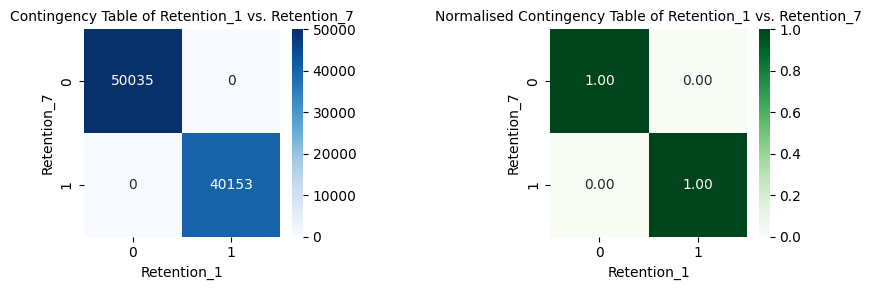

In [19]:
# Contingency tables of retention_1 vs. retention_7 (original and normalised)

def plot_contingency_tables(contingency_table):
    fig, axes = plt.subplots(1,2, figsize=(8, 3))
    fig.subplots_adjust(wspace= 1.2)

    sns.heatmap(contingency_table, cmap='Blues', annot=True, fmt='d', ax= axes[0])
    axes[0].set_title('Contingency Table of Retention_1 vs. Retention_7', fontsize=10)
    axes[0].set_xlabel('Retention_1')
    axes[0].set_ylabel('Retention_7')

    # Normalising contingency table to show proportions
    normalised_contingency_table = contingency_table / contingency_table.sum(axis=1).values.reshape(-1, 1)

    sns.heatmap(normalised_contingency_table, cmap='Greens', annot=True, fmt = '.2f', ax= axes[1]) 
    axes[1].set_title('Normalised Contingency Table of Retention_1 vs. Retention_7', fontsize=10)
    axes[1].set_xlabel('Retention_1')
    axes[1].set_ylabel('Retention_7')

    plt.tight_layout()
    plt.subplots_adjust(wspace= 0.9)  
    plt.show()

plot_contingency_tables(contingency_table)


In [20]:
# Logistic Regression for retention_1 ~ sum_gamerounds and retention_7 ~ sum_gamerounds
def logit_parameters(data, column, series):
    formula_str = f"{series} ~ {column}"
    logit_model = logit(formula_str, data=data).fit()
    log_odds = logit_model.params
    odds_ratio = np.exp(log_odds)
    percent_increase = (odds_ratio - 1) * 100
    return logit_model, log_odds, odds_ratio, percent_increase

logit_model_1, log_odds_1, odds_ratio_1, percent_increase_1 =  logit_parameters(cats_cleaned, 'sum_gamerounds', 'cats_cleaned_r1_int')   
logit_model_7, log_odds_7, odds_ratio_7, percent_increase_7  =  logit_parameters(cats_cleaned, 'sum_gamerounds', 'cats_cleaned_r7_int')   

print(f"\nLog-odds for retention_1: intercept: {log_odds_1['Intercept']}, sum_gamerounds: {log_odds_1['sum_gamerounds']}")
print(f"Log-odds for retention_7: intercept: {log_odds_7['Intercept']}, sum_gamerounds: {log_odds_7['sum_gamerounds']}")

print(f"\nOdds Ratio for sum_gamerounds in retention_1: {odds_ratio_1['sum_gamerounds']}")
print(f"Percentage increase for sum_gamerounds in retention_1: {percent_increase_1['sum_gamerounds']:.2f}%")

print(f"\nOdds Ratio for sum_gamerounds in retention_7: {odds_ratio_7['sum_gamerounds']}")
print(f"Percentage increase for sum_gamerounds in retention_7: {percent_increase_7['sum_gamerounds']:.2f}%")


Optimization terminated successfully.
         Current function value: 0.531454
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.332221
         Iterations 7

Log-odds for retention_1: intercept: -1.266331846155148, sum_gamerounds: 0.031031692277011295
Log-odds for retention_7: intercept: -2.7342700439995604, sum_gamerounds: 0.02085499635272344

Odds Ratio for sum_gamerounds in retention_1: 1.0315181945288627
Percentage increase for sum_gamerounds in retention_1: 3.15%

Odds Ratio for sum_gamerounds in retention_7: 1.02107398145098
Percentage increase for sum_gamerounds in retention_7: 2.11%
